# Contents
- [Data importing and Cleaning](#Data-importing-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Classification Modelling](#Classification-Modelling)
- [Data Visualization](#Visualize-the-Data)
- [Kaggle Submission](#Kaggle-Submission)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data importing and Cleaning

In [2]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import contractions

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize   
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.dates as mdate

import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec


from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from datetime import timezone
import datetime

pd.set_option('display.max_colwidth', None)

In [3]:
df_ptsd1 = pd.read_csv('../Data/PTSD.csv')
df_ptsd2 = pd.read_csv('../Data/PTSD2.csv')

In [4]:
df_ptsd1.shape

(10122, 7)

In [5]:
df_ptsd2.shape

(10122, 6)

In [6]:
# to create df_ptsd 
df_ptsd = pd.concat([df_ptsd1, df_ptsd2[['link_flair_css_class']]], axis = 1)
print(df_ptsd.shape)

(10122, 8)


In [7]:
df_anxiety = pd.read_csv('../Data/Anxiety.csv')

df_anxiety = df_anxiety.drop(columns = 'Unnamed: 0')
df_ptsd.drop(columns = 'Unnamed: 0', inplace = True)

df = pd.concat([df_ptsd,df_anxiety])
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)

In [8]:
df_ptsd2['link_flair_css_class'].unique()

array(['advice', 'discussion', 'support', 'success', 'venting', nan,
       'meta', 'resource'], dtype=object)

In [9]:
# both subreddits has venting as their filter 
df_anxiety['link_flair_css_class'].unique()

array(['relationshipflair', 'adviceneeded', 'daeflair', 'venting',
       'schoolflair', 'articleflair', 'books', 'medsflair', 'helpflair',
       'lovedones', 'healthflair', 'discussion', 'amapost',
       'introductions', 'helpfultips', 'victory-recurring', nan,
       'drivingflair', 'progressflair', 'trigger', 'artflair',
       'relaxingimgs', 'announcements', 'studyflair'], dtype=object)

In [10]:
df.shape

(20229, 7)

## Pre-Processing

Combining selftext and title into alltext

In [11]:
# create all text column for self text and title combined 

df['alltext'] = df['selftext'] + ' ' + df['title']

Calculate length of text and title

In [12]:
# to create calculate length of text and title 

df['length_text'] = df['alltext'].map(lambda x: len(x))

Word count per post

In [13]:
# to create calculate status word cout of text and title 
tokenizer = RegexpTokenizer('\s+', gaps=True)

def tokenizer_func(text):
    return len(tokenizer.tokenize(text))

df['wrdcount_text'] = df['alltext'].apply(lambda x: tokenizer_func(x))

Check for null values

In [14]:
# found NAN coming from the link filter
df.isnull().sum()

author                   0
subreddit                0
selftext                 0
title                    0
created_utc              0
datetime                 0
link_flair_css_class    73
alltext                  0
length_text              0
wrdcount_text            0
dtype: int64

In [15]:
# Fill rows sub flair to mode first
df.fillna(df['link_flair_css_class'].mode()[0], inplace = True)

I will now **create the target variable** to be used in classification modelling. From this point forward in all classification models, the **positive class (1) will be *r/PTSD*** and the **negative class (0) will be *r/Anxiety***.

In [16]:
# change Ptsd to 1 and Anxiety to 0

df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'ptsd' else 0)

Create datetime object into another column

In [17]:
# Converting 'created_utc' column from epoch time to datetime object.

df['datetime'] = df['created_utc'].map(lambda ts: datetime.datetime.fromtimestamp(ts))

In [18]:
def change_month(month):
    convert = month.to_pydatetime().month
    month_dict = {
        1: 'Jan',
        2: 'Feb',
        3: 'Mar',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: "Aug",
        9: 'Sept',
        10: 'Oct',
        11: 'Nov',
        12: 'Dec'
    }

    return month_dict[convert]

df['month'] = df['datetime'].apply(lambda x: x.to_pydatetime().month)

In [19]:
df['day'] = df['datetime'].apply(lambda x: x.strftime('%A'))

### Cleaning text - Without Lemmatizing/stemming

I will be defining a function that helps to do the following: 

- **Remove HTML artefacts** using *BeautifulSoup* library.
- **Expand all contractions** using *contractions* library.
- **Remove all numbers, punctuations and special characters, except '-'** to keep hyphenated words, using *re* library.
- **Convert all text to lowercase**.
- **Tokenize all words (hyphenated words stay hyphenated)** using *RegexpTokenizer* from *nltk.tokenize*.
- **Remove all stopwords** using the english stopwords list from *nltk.corpus*.
- **Remove subreddit names** *('PTSD', 'Anxiety')* and other related words to avoid **target leakage**.
- **Join all tokenized words** into a string separated by spaces.

Stemming/Lemmatizing of words will be done during error analysis. 

In [20]:
# Defining a function to clean all_text column following the steps mentioned above.
def clean_text(text_raw):
    
    # Removing any and all HTML artefacts from the text (just in case reddit API still left behind some).
    text_html_removed = BeautifulSoup(text_raw).get_text()
    
    # Expanding all contractions using the contractions library (for example isn't is converted to is not).
    text_contrac_fixed = contractions.fix(text_html_removed)
    
    # Using regex to remove all numbers, punctuations and special characters (except '-' to keep hyphenated words).
    text_punc_removed = re.sub(r'[^A-Za-z\-\s]', ' ', text_contrac_fixed)
    
    # Tokenizing the text after converting it to lowercase.
    # Regex here tokenizes by every character except one or more ('+') consecutive word characters ('\w') or hyphens ('-').
    text_tokens_list = RegexpTokenizer(r'[\w\-]+').tokenize(text_punc_removed.lower())
    
    # Removing stopwords using the english stopwords list from nltk.corpus.
    text_stopwords_removed = [word for word in text_tokens_list if word not in set(nltk.corpus.stopwords.words('english'))]
    
    # Removing subreddit name from text (target leakage).
    text_cleaned = [word for word in text_stopwords_removed if word not in set(['ptsd', 'anxious', 'anxiety',"cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic"])]
    
    # Returning a string of all tokenized words joined together with spaces in between.
    return " ".join(text_cleaned)

In [21]:
df['clean_text']= df['alltext'].apply(lambda x: clean_text(x)) 

In [ ]:
# getting total number of post per unique users
unique_counts = pd.DataFrame(df.groupby('author')['subreddit'].count())
unique_counts.reset_index(inplace = True)
unique_counts

,author,subreddit
0,---Scotty---,1
1,--A-lost-soul--,1
2,--Eug--,1
3,--Nature--,1
4,-7hr0w4w4y-,1
...,...,...
13567,zwitterion76,1
13568,zylonrave,1
13569,zynopsis61,1
13570,zzfailureloser123,1


Need to create ttl_post and user_contribute_where to assign to unique users for EDA analysis

In [ ]:
# To create one column called ttl_post to append total number of post for each user
# TO BE USED ONLY using unique_users dataframe below 
df = df.merge(unique_counts, on = 'author')
df.rename(columns = {'subreddit_x': 'subreddit', 'subreddit_y': 'ttl_post'}, inplace = True)

In [ ]:
# to create reference list for identify columns with ptsd/anxiety or both
unique_list_for_ptsd = df[df['subreddit'] == 1]['author'].unique().tolist()
unique_list_for_anxiety = df[df['subreddit'] == 0]['author'].unique().tolist()


# def function that labels  ptsd_only, anxiety_only , both

def identify_users(user):
    if (user in unique_list_for_ptsd) & (user not in unique_list_for_anxiety):
        return 'ptsd_only'

    elif (user not in unique_list_for_ptsd) & (user in unique_list_for_anxiety):
        return 'anxiety_only'

    else:
        return 'both'


df['user_contribute_where'] = df['author'].apply(identify_users)

In [ ]:
# create separate data frame to consist of only unique users 
unique_users = pd.DataFrame(df['author'].unique())
unique_users = pd.concat([unique_users,df], axis = 1).dropna()
unique_users.drop(columns = 0, inplace = True)

In [ ]:
# This dataframe is used to compare total post 
ptsd_unique = unique_users[unique_users['user_contribute_where'] == 'ptsd_only']
anxiety_unique = unique_users[unique_users['user_contribute_where'] == 'anxiety_only']

In [ ]:
# creating dataframe for analysis on length and word counts. 
ptsd = df[df['subreddit'] == 1]
anxiety = df[df['subreddit'] == 0]
anxiety.reset_index(inplace = True)
anxiety = anxiety.drop(columns = 'index')

In [ ]:
unique_users.columns

Index(['author', 'subreddit', 'selftext', 'title', 'created_utc', 'datetime',
       'link_flair_css_class', 'alltext', 'length_text', 'wrdcount_text',
       'month', 'day', 'clean_text', 'ttl_post', 'user_contribute_where'],
      dtype='object')

###  Summary of Data-processing 

- Filled up NAN with mode
- Text Cleanup including tokenizing, remove html, remove stopwords, remove numbers and punctuations

Created following columns:
1) create datetime column using created_utc to convert
2) alltext - Combining selftext and title 
3) length_text - Length of text 
4) wrdcount_text - total counts of words per post


## Exploratory Data Analysis

### Visualizing differences in length of text 


In [ ]:
# creating focused dataframe to zoom into ALL USERS who are venting and belong to either one of the subreddits 
# this is to cater for only those who might be actually suffereing from either one of the groups 
df_all_users = df[(df['user_contribute_where'] != 'both')]

# To find out total length and word count per post for each subreddit groups
df_all_users.groupby(by = 'subreddit')[['length_text','wrdcount_text']].agg(['count', 'mean'])

length_text              wrdcount_text            
                count         mean         count        mean
subreddit                                                   
0                9956   857.021193          9956  162.368321
1                9921  1149.748009          9921  217.444411

### Plotting Scatterplot of Length of text in each post, hue by subreddits  

Text(0.5, 1.0, 'Scatterplot showing number of length of text on both subreddits')

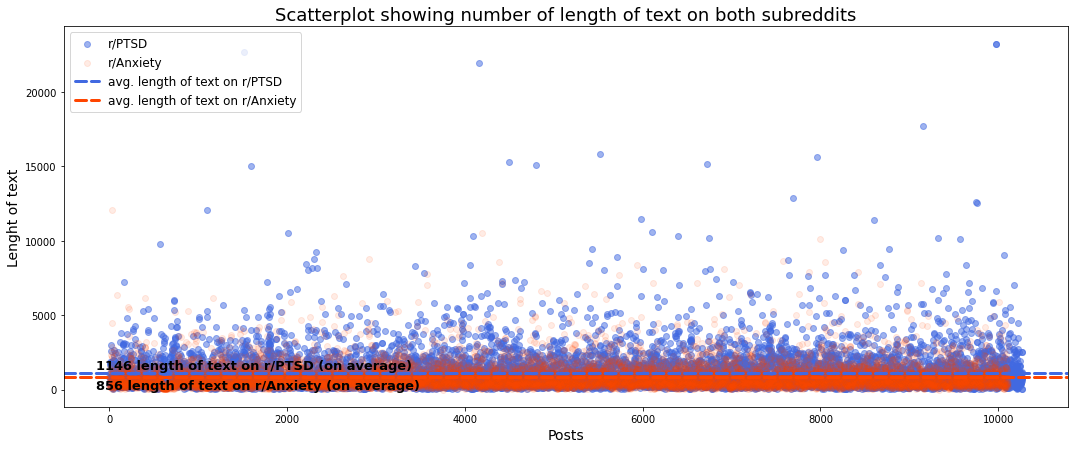

In [ ]:
# Plotting scatterplot to show no. of length of text on both subreddits.

fig, ax = plt.subplots(figsize=(18,7))

plt.scatter(ptsd.index, ptsd['length_text'], color='royalblue', alpha=0.5, label='r/PTSD')
plt.scatter(anxiety.index, anxiety['length_text'], color='orangered', alpha=0.1, label='r/Anxiety')

# Plotting horizontal lines to show average no. of words for posts in both subreddits.
plt.axhline(ptsd['length_text'].mean(),
            label='avg. length of text on r/PTSD',
            ls='--',
            linewidth=3,
            color='royalblue',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.20,
            s=f"{int(round(ptsd['length_text'].mean(), 0))} length of text on r/PTSD (on average)",
            fontsize=13,
            fontweight='semibold'
           )

plt.axhline(anxiety['length_text'].mean(),
            label='avg. length of text on r/Anxiety',
            ls='--',
            linewidth=3,
            color='orangered',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.16,
            s=f"{int(round(anxiety['length_text'].mean(), 0))} length of text on r/Anxiety (on average)",
            fontsize=13,
            fontweight='semibold'
           )


plt.legend(fontsize=12)

plt.xlabel("Posts", fontsize=14)
plt.ylabel("Lenght of text", fontsize=14)

plt.title("Scatterplot showing number of length of text on both subreddits", loc='center', fontsize=18)

Generally the length of text, number of words and even total number of post per users is higher in r/PTSD than in r/Anxiety. 

To visualise more, we plot a scatterplot for that shows the average length of text on both subrredicts. On average, the length text for r/PTSD is 1146 while the length of text for r/Anxiety is 853. 

Also we can see majority of the longer post are coming from users in r/PTSD. This shows that users in r/PTSD are definitely more active in the subreddit, suggesting they might have alot more to share or ask in the forum about their experience before getting PTSD. 

As users who might be suffering from PTSD has more specific relation to trauma genericly, people who can relate more to these post, will likely to share their experiences/advice as to how to perhaps overcome such grave issues as compared to having assumingly generic anxiety. 

In [ ]:
# Filtering users who post more than 10000 length of text 

long_poster = df[df['length_text'] > 8000]

long_poster.groupby('author')['subreddit'].sum().sort_values(ascending = False).head(10)

author
Available_Yoghurt_83    2
EcstaticBunny           2
-Tali                   1
eucalyptuselephant      1
Soft-Clue-6345          1
SonicDeathMareczku      1
TheFlyingBeltDude       1
TheGiraffeEater         1
Zealousideal_Desk100    1
Zestyclose-Ad4610       1
Name: subreddit, dtype: int64

To sanity check on frequest users who post alot, there seem to be one-off users posting lengthy post in the subreddits.

### Visualising Unique users activity levels

In [ ]:
ptsd_user = len(df[df['user_contribute_where'] == 'ptsd_only']['author'].unique())
anxiety_user = len(df[df['user_contribute_where'] == 'anxiety_only']['author'].unique())
both_user = len(df[df['user_contribute_where'] == 'both']['author'].unique())

print(f'Number of users in r/PTSD only is {ptsd_user}')
print(f'Number of users in r/Anxiety only is {anxiety_user}')
print(f'Number of users in both subreddits is {both_user}')

print(f'Total number of unique users is {ptsd_user + anxiety_user + both_user}')

Number of users in r/PTSD only is 6190
Number of users in r/Anxiety only is 7289
Number of users in both subreddits is 93
Total number of unique users is 13572


Text(0, 0.5, 'Number of post')

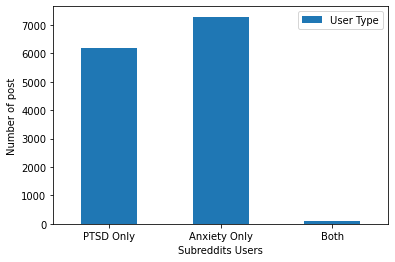

In [ ]:
# plotting unique user types in each subreddit page

bar_users = pd.DataFrame({'Class':['PTSD Only', 'Anxiety Only', 'Both'], 'User Type':[ptsd_user, anxiety_user, both_user]})
x_labels = [ptsd_user,anxiety_user, both_user]

ax = bar_users.plot.bar(x='Class', y='User Type', rot=0)
ax.set_xlabel("Subreddits Users")
ax.set_ylabel("Number of post")


We can see that there are much unique users in Anxiety more than PTSD over a span of 100000 post on reddit, suggesting that Anxiety might be more common than PTSD. In fact, based on ([*source*](https://adaa.org/understanding-anxiety/facts-statistics)), PTSD accounts for 3.5% of US population, while Anxiety, consisting of GAD - General Anxiety Disorder and Social Anxiety Disorder accounts for 10% of the population.

Need to take note that there are 92 users who are using both subreddits, this may bring in ambiguity and inaccuracy as to whether or not these users has PTSD or not.

When modeling, we can consider removing accounts from these users, and recalculate accuracy

#### Comparing Total post

In [ ]:
# This dataframe is used to compare total post and duration from first to last post 
ptsd_unique = unique_users[unique_users['user_contribute_where'] == 'ptsd_only']
anxiety_unique = unique_users[unique_users['user_contribute_where'] == 'anxiety_only']

In [ ]:
ttl_post_ptsd_mean = round(ptsd_unique['ttl_post'].mean(),0)
ttl_post_anxiety_mean = round(anxiety_unique['ttl_post'].mean(),0)
print(f'Average total post for unique users in PTSD: {ttl_post_ptsd_mean}')
print(f'Average total post for unique users in Anxiety: {ttl_post_anxiety_mean}')

Average total post for unique users in PTSD: 5.0
Average total post for unique users in Anxiety: 7.0


We can see that for each unique users in both subreddits, users in r/Anxiety is highly active as compared to users from r/PTSD. 
On average, users from r/Anxiety post close to 7 post while r/PTSD users post up to 5 post. 

In [ ]:
# Timespan between creation of latest post scraped and earliest post scraped from r/ptsd_unique.

ptsd_unique_time_diff = ptsd_unique['datetime'].max() - ptsd_unique['datetime'].min()
ptsd_unique_time_diff

Timedelta('337 days 04:58:54')

In [ ]:
# Timespan between creation of latest post scraped and earliest post scraped from r/anxiety_unique.

anxiety_unique_time_diff = anxiety_unique['datetime'].max() - anxiety_unique['datetime'].min()
anxiety_unique_time_diff

Timedelta('45 days 08:26:48')

In [ ]:
ptsd_unique_time_diff_h = (ptsd_unique_time_diff.seconds//3600) + (ptsd_unique_time_diff.days * 24)
anxiety_unique_time_diff_h = (anxiety_unique_time_diff.seconds//3600) + (anxiety_unique_time_diff.days * 24)

ptsd_ave_post_hr = ptsd_unique.shape[0] / ptsd_unique_time_diff_h
anxiety_ave_post_hr = anxiety_unique.shape[0] / anxiety_unique_time_diff_h

print("Average no. of posts created per hour:")
print(f"r/PTSD \t= {round(ptsd_ave_post_hr, 2)}")
print(f"r/Anxiety = {round(anxiety_ave_post_hr, 2)}")

Average no. of posts created per hour:
r/PTSD 	= 1.23
r/Anxiety = 3.03


As seen from above, both subreddits are quite active. However, it is significant to also say that r/Anxiety is significantly more active than r/PTSD, with almost 2.5 times more for average no of post created per hour

We can also infer that there is more likely chance users will have Anxiety than having PTSD. Question is how will our model help identifying them correctly. Lets visualise below on unique users activity levels

### Visualising Timeline across both reddits vs number of post 

Text(0.5, 1.0, 'Histogram showing distribution of posts created on r/PTSD and r/Anxiety')

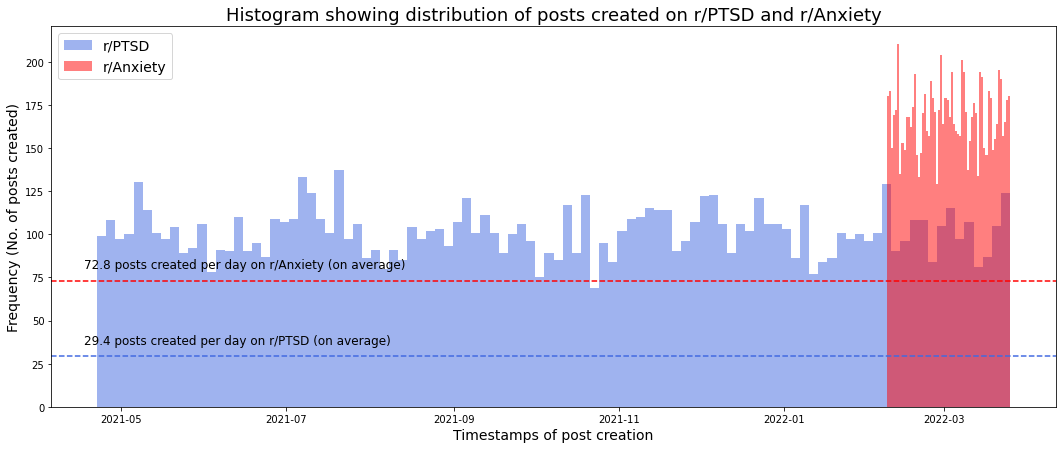

In [ ]:
# Plotting histograms to show no. of posts created over time.

fig, ax = plt.subplots(figsize=(18,7))

plt.hist(ptsd['datetime'], bins=100, color='royalblue', alpha=0.5, label='r/PTSD')
plt.hist(anxiety['datetime'], bins=60, color='red', alpha=0.5, label='r/Anxiety')


# Plotting horizontal lines to show average no. of posts created per hour.
plt.axhline(ptsd_ave_post_hr*24, ls='--', color='royalblue')
plt.figtext(x=0.15, y=0.25, s=f"{round(ptsd_ave_post_hr*24, 1)} posts created per day on r/PTSD (on average)", fontsize=12)

plt.axhline(anxiety_ave_post_hr*24, ls='--', color='red')
plt.figtext(x=0.15, y=0.4, s=f"{round(anxiety_ave_post_hr*24, 1)} posts created per day on r/Anxiety (on average)", fontsize=12)


plt.legend(fontsize=14)

plt.xlabel("Timestamps of post creation", fontsize=14)
plt.ylabel("Frequency (No. of posts created)", fontsize=14)

plt.title("Histogram showing distribution of posts created on r/PTSD and r/Anxiety", loc='center', fontsize=18)

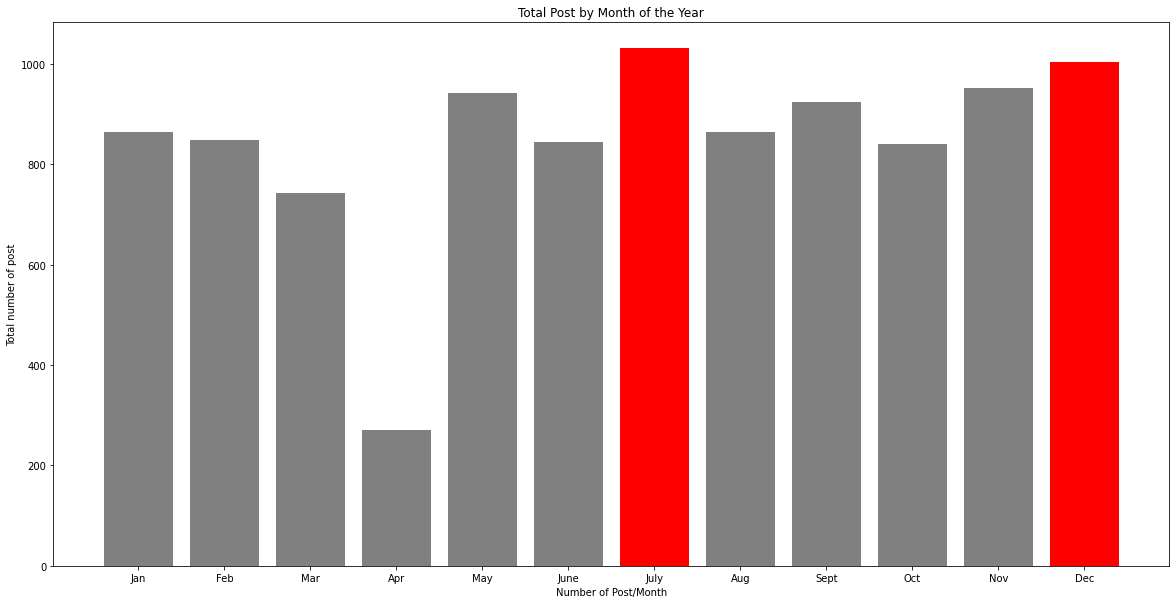

In [ ]:
plt.figure(figsize = (20, 10))

        
# add some colors
plt.bar(
        ['Jan','Feb', 'Mar','Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
        [(ptsd['month'] == num).sum() for num in np.arange(1,13)],
        color = ['grey','grey','grey','grey','grey','grey','Red','grey','grey','grey','grey','Red']
)
plt.title('Total Post by Month of the Year')
plt.xlabel('Number of Post/Month')
plt.ylabel('Total number of post');

**Comments**

- Overall, we can see that the activity in r/PTSD is relatively the same across, having peaks on every other month ie, 2021-05, 2021-07, 2021-09 and 2021-12 having high peaks while 2021-06, 2021-08 having lower peaks. This cyclical trend over time might 

- When looking at month on year, we can generally see a similar cyclical trend as well. This could be attributed to some sort of SAD, short form for Seasonal Affective Disorder, commonly known as a seasonal depression or the winter depression. The ([*source*](https://www.psychiatry.org/patients-families/depression/seasonal-affective-disorder#:~:text=The%20symptoms%20usually%20occur%20during,experience%20SAD%20in%20the%20summer.)) suggest that people suffering from this tend to exhibit symtoms of depression when there is less sunlight.  

- We can see general trending similar across the month of 2022-03 across both subreddits suggesting that it really could be subjected due to seasonal effects like sunlight and weather variables.([*source*](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0192568))  

### Checking most common words

In [ ]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety','anxious', "cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic", 'www', 'https', 'mentalgrenade', 'com']
for head in headers:
    stopwordlist.append(head)

#### Using CountVectorizer

In [ ]:
#Setting X and y
X = df['clean_text']
y = df['subreddit']

#instantiate vectorizer
cvec = CountVectorizer(
    stop_words= stopwordlist,   #adding stop
    strip_accents = 'ascii', #removing non-ASCII and extended ASCII characters
    max_features = 5000,
    max_df=0.8,
    min_df = 0.2     #setting arbitrary value
    )

#fitting and transforming
X = cvec.fit_transform(X)

#saving results into a sparse DataFrame
X_df = pd.DataFrame(X.todense(), 
                          columns=cvec.get_feature_names_out())

#adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

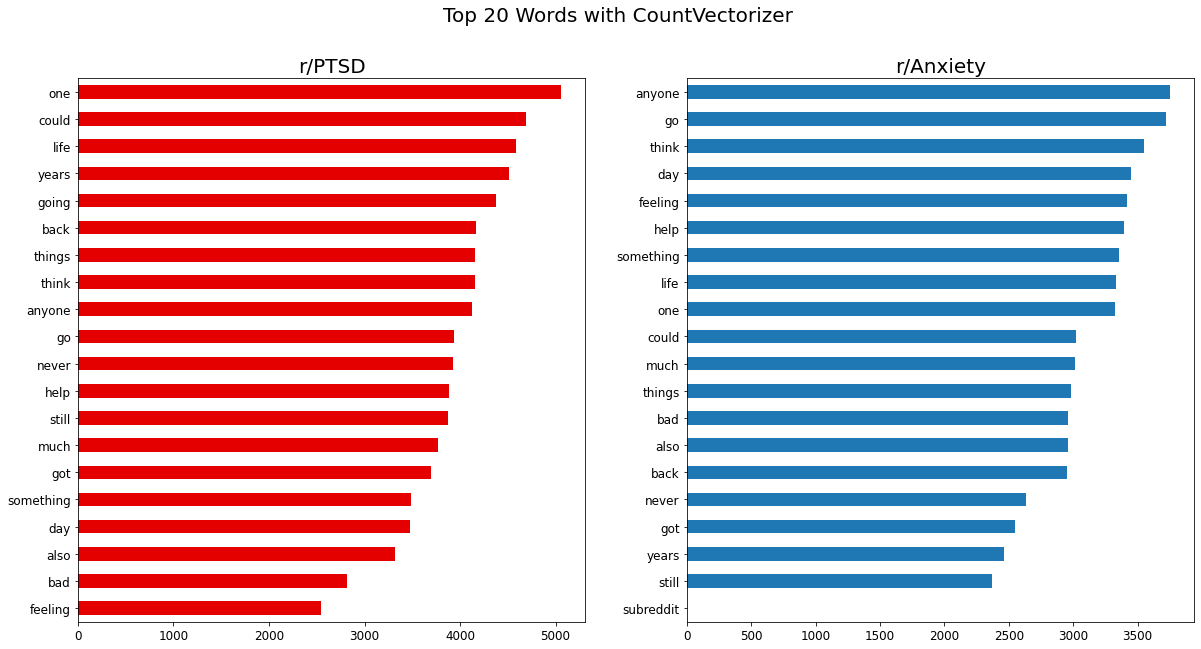

In [ ]:
#plotting top words for vectorizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Top 20 Words with CountVectorizer', size = 20)

common_words[common_words['subreddit'] == 1].drop(columns='subreddit').sum().sort_values().head(20).plot(kind='barh', fontsize = 12, color = ('xkcd:red'), ax=ax1)

ax1.set_title('r/PTSD', size = 20);

common_words[common_words['subreddit'] == 0].sum().sort_values().head(20).plot(kind='barh', fontsize = 12, ax=ax2)

ax2.set_title('r/Anxiety', size = 20);

No significant finding for common words - no distinguishing words able to differentiate subreddits

#### Using TfidVectorizer

In [ ]:
#Setting X and y
X = df['clean_text']
y = df['subreddit']

#instantiate vectorizer
cvec = TfidfVectorizer(
    stop_words= stopwordlist,   #adding stop
    strip_accents = 'ascii', #removing non-ASCII and extended ASCII characters
    max_features = 5000,
    max_df=0.8,
    min_df = 0.2     #setting arbitrary value
    )

#fitting and transforming
X = cvec.fit_transform(X)

#saving results into a sparse DataFrame
X_df = pd.DataFrame(X.todense(), 
                          columns=cvec.get_feature_names_out())

#adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

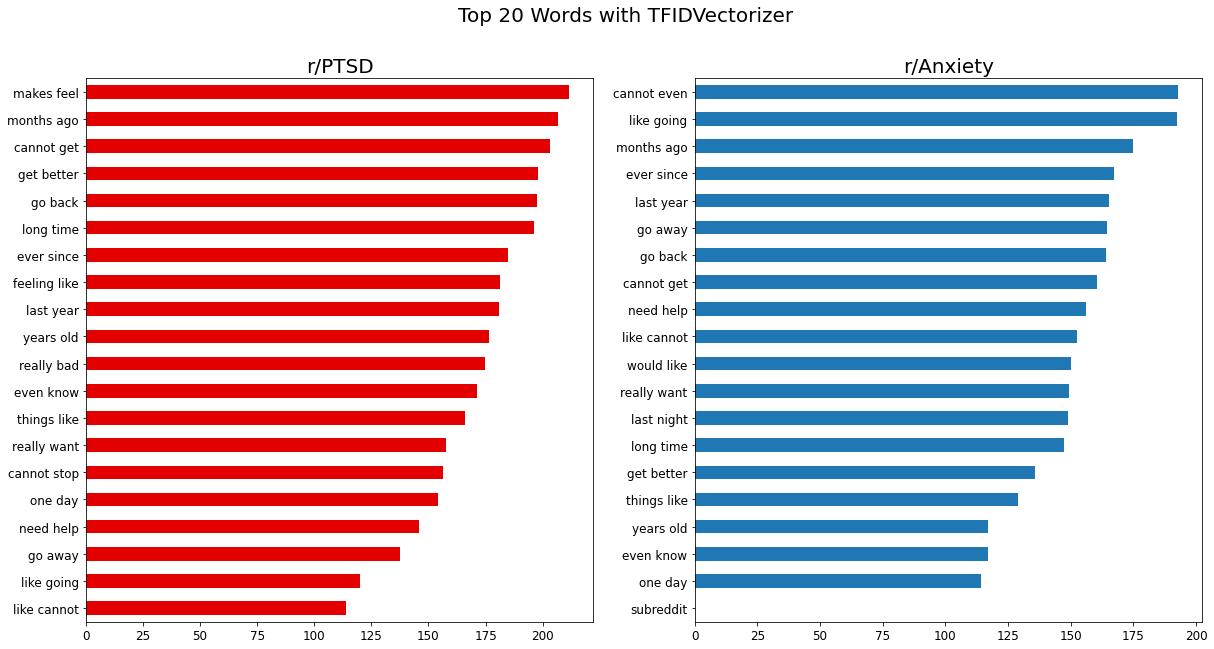

In [ ]:
#plotting top words for vectorizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Top 20 Words with TFIDVectorizer', size = 20)

common_words[common_words['subreddit'] == 1].drop(columns='subreddit').sum().sort_values().head(20).plot(kind='barh', fontsize = 12, color = ('xkcd:red'), ax=ax1)

ax1.set_title('r/PTSD', size = 20);

common_words[common_words['subreddit'] == 0].sum().sort_values().head(20).plot(kind='barh', fontsize = 12, ax=ax2)

ax2.set_title('r/Anxiety', size = 20);

noticed that there is `year` from r/PTSD and r/Anxiety, this indicates certain time aspect which may be long term as is so frequently used in r/PTSD as compared to r/Anxiety. 

### Checking most common bigrams/trigrams

In [ ]:
#Setting X and y
X = df['clean_text']
y = df['subreddit']

#instantiate vectorizer
cvec = TfidfVectorizer(
    stop_words= stopwordlist,   #adding stop
    strip_accents = 'ascii', #removing non-ASCII and extended ASCII characters
    max_features = 5000,
    max_df=0.97,
    min_df = 0.02,
    ngram_range=(2,2)    #setting arbitrary value
    )

#fitting and transforming
X = cvec.fit_transform(X)

#saving results into a sparse DataFrame
X_df = pd.DataFrame(X.todense(), 
                          columns=cvec.get_feature_names_out())

#adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

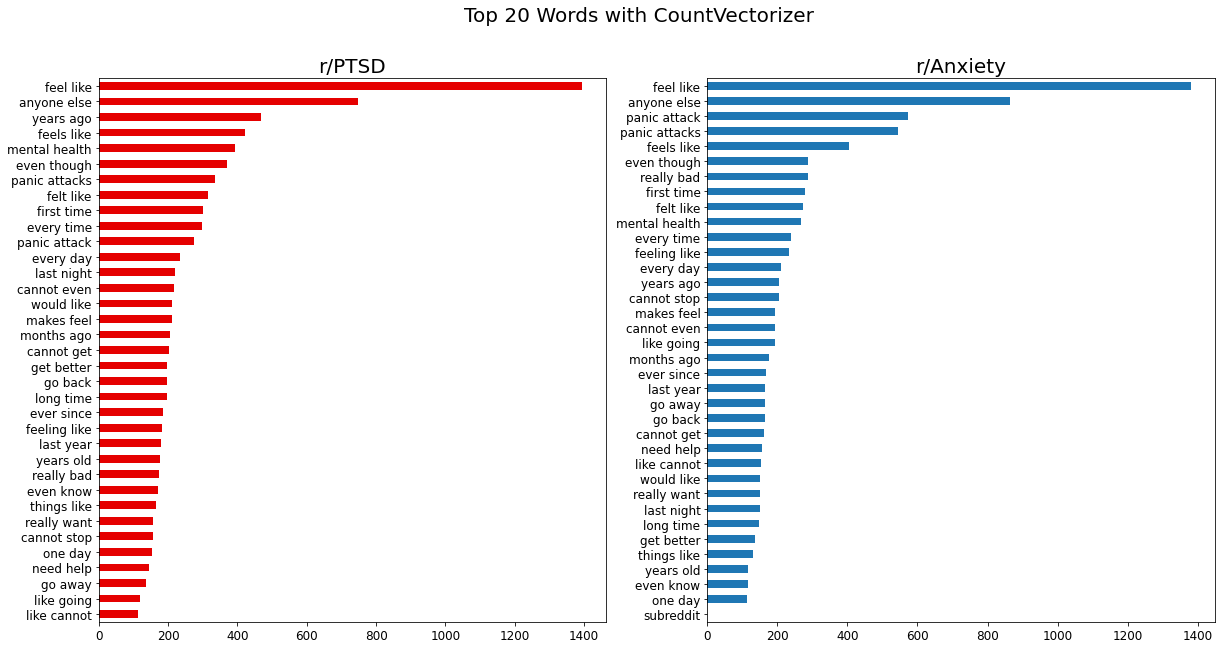

In [ ]:
#plotting top words for vectorizer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Top 20 Words with CountVectorizer', size = 20)

common_words[common_words['subreddit'] == 1].drop(columns='subreddit').sum().sort_values().plot(kind='barh', fontsize = 12, color = ('xkcd:red'), ax=ax1)

ax1.set_title('r/PTSD', size = 20);

common_words[common_words['subreddit'] == 0].sum().sort_values().plot(kind='barh', fontsize = 12, ax=ax2)

ax2.set_title('r/Anxiety', size = 20);

We can see both subreddits display common bigrams like panic attack and mental help. 

I did observe that ***years ago*** appeared as top common wods in r/PTSD, more common than in r/Anxiety, illustrating a time effect. This suggest that there might be longer term effects as compared to r/Anxiety. From ([*source*](https://www.medicalnewstoday.com/articles/156285)) ,it suggest that a person diagnosed with PTSD amy take longer to heal. 


## Lemmatize/Stemming and save file

In [ ]:
# Defining a function to stem words from all_text_cleaned column.
def stem_words(text):
    
    # Stemming all words using list comprehension.
    text_stemmed = [PorterStemmer().stem(word) for word in text.split(" ")]
    
    # Returning a string of all words joined together with spaces in between.
    return " ".join(text_stemmed)

df['stem_clean_text'] = df['clean_text'].map(lambda x: stem_words(x))

In [ ]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

# define function that takes in words from paragraph, and lemmitize and join back as paragraph
def lemmi_words(text):
    return ' '.join([lemmatizer.lemmatize(i) for i in text.split(' ')])

df['lemmi_clean_text'] = df['clean_text'].map(lambda x: lemmi_words(x))

In [ ]:
df.to_csv('../Data/df.csv')